In [32]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import timezone
import pickle as pkl
import tldextract
from sklearn.model_selection import train_test_split


In [2]:

train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')


train_df.shape, test_df.shape



# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

#full_df[:].fillna(method='bfill',inplace=True)

# Index to split the training and test data sets
idx_split = train_df.shape[0]

full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11


In [3]:
#full_df = train_df.sample(1000)


0    251264
1      2297
Name: target, dtype: int64


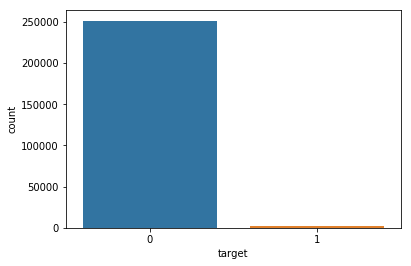

In [5]:
sns.countplot(train_df['target']) #Imbalanced Dataset
print(train_df.target.value_counts())

In [6]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
full_df[times] = full_df[times].apply(pd.to_datetime)


# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
full_df[sites] = full_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pkl.load(input_file)

site_dict = {y:x for x,y in site_dict.items()}
site_dict[0] = 'None'



# Create dataframe for the dictionary
#sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
#print(u'Websites total:', sites_dict.shape[0])

In [7]:
# Dataframe for new features
full_df_feat = pd.DataFrame(index=full_df.index)

# Add time features
full_df_feat['month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
full_df_feat['day'] = full_df['time1'].apply(lambda ts: ts.day)
full_df_feat['dow'] = full_df['time1'].apply(lambda x: x.date().weekday())
full_df_feat['count'] = full_df[times].apply(lambda x: x.nunique(), axis=1)
full_df_feat.head()

,month,day,dow,count
session_id,,,,
1,201402,20,3,1
2,201402,22,5,5
3,201312,16,0,7
4,201403,28,4,10
5,201402,28,4,6


In [8]:
for t in times:
    col = 'hour' + t.replace('time','')
    full_df_feat[col] = full_df[t].apply(lambda ts: ts.hour)
    
    col = 'minute' + t.replace('time','')
    full_df_feat[col] = full_df[t].apply(lambda ts: ts.minute)
    
    col = 'second' + t.replace('time','')
    full_df_feat[col] = full_df[t].apply(lambda ts: ts.second)

    
full_df_feat.head()

,month,day,dow,count,hour1,minute1,second1,hour2,minute2,second2,...,second7,hour8,minute8,second8,hour9,minute9,second9,hour10,minute10,second10
session_id,,,,,,,,,,,,,,,,,,,,,
1,201402,20,3,1,10,2,45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201402,22,5,5,11,19,50,11.0,19.0,50.0,...,52.0,11.0,19.0,52.0,11.0,20.0,15.0,11.0,20.0,16.0
3,201312,16,0,7,16,40,17,16.0,40.0,18.0,...,20.0,16.0,40.0,21.0,16.0,40.0,22.0,16.0,40.0,24.0
4,201403,28,4,10,10,52,12,10.0,52.0,42.0,...,12.0,10.0,55.0,42.0,10.0,56.0,12.0,10.0,56.0,42.0
5,201402,28,4,6,10,53,5,10.0,55.0,22.0,...,59.0,10.0,55.0,59.0,10.0,57.0,6.0,10.0,57.0,11.0


In [9]:
time_df = pd.DataFrame(index=full_df.index)

# Find sessions' starting and ending
time_df['min'] = full_df[times].min(axis=1)
time_df['max'] = full_df[times].max(axis=1)


# Calculate sessions' duration in seconds
full_df_feat['duration'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

full_df_feat.head(20)

,month,day,dow,count,hour1,minute1,second1,hour2,minute2,second2,...,hour8,minute8,second8,hour9,minute9,second9,hour10,minute10,second10,duration
session_id,,,,,,,,,,,,,,,,,,,,,
1,201402,20,3,1,10,2,45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,201402,22,5,5,11,19,50,11.0,19.0,50.0,...,11.0,19.0,52.0,11.0,20.0,15.0,11.0,20.0,16.0,26.0
3,201312,16,0,7,16,40,17,16.0,40.0,18.0,...,16.0,40.0,21.0,16.0,40.0,22.0,16.0,40.0,24.0,7.0
4,201403,28,4,10,10,52,12,10.0,52.0,42.0,...,10.0,55.0,42.0,10.0,56.0,12.0,10.0,56.0,42.0,270.0
5,201402,28,4,6,10,53,5,10.0,55.0,22.0,...,10.0,55.0,59.0,10.0,57.0,6.0,10.0,57.0,11.0,246.0
6,201403,18,1,5,15,18,31,15.0,18.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686.0
7,201402,13,3,6,16,45,35,16.0,45.0,35.0,...,16.0,47.0,15.0,16.0,47.0,16.0,16.0,47.0,17.0,102.0
8,201304,12,4,5,10,27,26,10.0,27.0,26.0,...,10.0,27.0,31.0,10.0,27.0,31.0,10.0,27.0,32.0,6.0
9,201403,17,0,5,16,23,8,16.0,23.0,35.0,...,16.0,23.0,52.0,16.0,23.0,52.0,16.0,23.0,53.0,45.0


In [10]:
def url_extract(url):
    try:
        return tldextract.extract(url)
    except:
        return None


for col in sites:
    name = 'subdomain' + col.replace('site','')
    full_df_feat[name] = full_df[col].apply(lambda row: url_extract(site_dict[row])[0])
    
    name = 'domain' + col.replace('site','')
    full_df_feat[name] = full_df[col].apply(lambda row: url_extract(site_dict[row])[1])  

    name = 'suffix' + col.replace('site','')
    full_df_feat[name] = full_df[col].apply(lambda row: url_extract(site_dict[row])[2])





full_df_feat.head()

,month,day,dow,count,hour1,minute1,second1,hour2,minute2,second2,...,suffix7,subdomain8,domain8,suffix8,subdomain9,domain9,suffix9,subdomain10,domain10,suffix10
session_id,,,,,,,,,,,,,,,,,,,,,
1,201402,20,3,1,10,2,45,NaN,NaN,NaN,...,,,None,,,None,,,None,
2,201402,22,5,5,11,19,50,11.0,19.0,50.0,...,com,khms1,google,com,,193.164.197.30,,,193.164.196.60,
3,201312,16,0,7,16,40,17,16.0,40.0,18.0,...,com,cbk0,googleapis,com,cbk0,googleapis,com,cbk0,googleapis,com
4,201403,28,4,10,10,52,12,10.0,52.0,42.0,...,org,,annotathon,org,,annotathon,org,,annotathon,org
5,201402,28,4,6,10,53,5,10.0,55.0,22.0,...,org,fr,wikipedia,org,fr,wikipedia,org,meta,wikimedia,org


In [11]:
for i in range(1, 11):
    col0 = 'time%s'% str(i-1)
    col1 = 'time%s'% i
    name = 'duration%s'% i
    try:
        full_df_feat[name] = (full_df[col1] - full_df[col0]).apply(lambda row: row / np.timedelta64(1, 's'))
    except:
        full_df_feat[name] = 0

print(full_df_feat.head())

             month  day  dow  count  hour1  minute1  second1  hour2  minute2  \
session_id                                                                     
1           201402   20    3      1     10        2       45    NaN      NaN   
2           201402   22    5      5     11       19       50   11.0     19.0   
3           201312   16    0      7     16       40       17   16.0     40.0   
4           201403   28    4     10     10       52       12   10.0     52.0   
5           201402   28    4      6     10       53        5   10.0     55.0   

            second2     ...      duration1  duration2  duration3  duration4  \
session_id              ...                                                   
1               NaN     ...              0        NaN        NaN        NaN   
2              50.0     ...              0        0.0        1.0        0.0   
3              18.0     ...              0        1.0        1.0        0.0   
4              42.0     ...              0  

In [12]:
categorials = ['month', 'day', 'dow', 'hour1', 'minute1', 'second1', 'hour2',
    'minute2', 'second2', 'hour3', 'minute3', 'second3', 'hour4', 'minute4',
    'second4', 'hour5', 'minute5', 'second5', 'hour6', 'minute6', 'second6',
    'hour7', 'minute7', 'second7', 'hour8', 'minute8', 'second8', 'hour9',
    'minute9', 'second9', 'hour10', 'minute10', 'second10',
    'subdomain1', 'domain1', 'suffix1', 'subdomain2', 'domain2', 'suffix2',
    'subdomain3', 'domain3', 'suffix3', 'subdomain4', 'domain4', 'suffix4',
    'subdomain5', 'domain5', 'suffix5', 'subdomain6', 'domain6', 'suffix6',
    'subdomain7', 'domain7', 'suffix7', 'subdomain8', 'domain8', 'suffix8',
    'subdomain9', 'domain9', 'suffix9', 'subdomain10', 'domain10',
    'suffix10']

for col in full_df_feat.columns:
    if col in categorials:
        full_df_feat[col] = full_df_feat[col].fillna(9999)
        full_df_feat[col] = pd.Categorical(full_df_feat[col])
    else:
        full_df_feat[col] = full_df_feat[col].fillna(0)



    





In [13]:

subdomain = []
domain = []
suffix = []


for i in range(1, 11):
    col = 'subdomain%s'% i
    subdomain = subdomain + list(full_df_feat[col])
    
    col = 'domain%s'% i
    domain = domain + list(full_df_feat[col])
    
    col = 'suffix%s'% i
    suffix = suffix + list(full_df_feat[col])

    
    
subdomain = list(set(subdomain))
domain = list(set(domain))
suffix = list(set(suffix))

In [14]:
le_subdomain = LabelEncoder()
le_subdomain.fit(subdomain)  


le_domain = LabelEncoder()
le_domain.fit(domain)  

le_suffix = LabelEncoder()
le_suffix.fit(suffix)  



LabelEncoder()

In [15]:

    
for i in range(1, 11):
    col = 'subdomain%s'% i
    full_df_feat[col] = le_subdomain.transform(full_df_feat[col])
    
    col = 'domain%s'% i
    full_df_feat[col] = le_domain.transform(full_df_feat[col])
    
    col = 'suffix%s'% i
    full_df_feat[col] = le_suffix.transform(full_df_feat[col])

print(full_df_feat.head())

             month day dow  count hour1 minute1 second1   hour2 minute2  \
session_id                                                                
1           201402  20   3      1    10       2      45  9999.0  9999.0   
2           201402  22   5      5    11      19      50    11.0    19.0   
3           201312  16   0      7    16      40      17    16.0    40.0   
4           201403  28   4     10    10      52      12    10.0    52.0   
5           201402  28   4      6    10      53       5    10.0    55.0   

           second2    ...     duration1 duration2 duration3 duration4  \
session_id            ...                                               
1           9999.0    ...             0       0.0       0.0       0.0   
2             50.0    ...             0       0.0       1.0       0.0   
3             18.0    ...             0       1.0       1.0       0.0   
4             42.0    ...             0      30.0      30.0      30.0   
5             22.0    ...           

In [16]:
print(full_df_feat[col])

session_id
1          0
2          0
3         61
4        215
5        215
6          0
7         61
8        197
9         61
10       123
11        61
12        61
13        61
14        61
15        61
16        61
17       197
18        61
19        61
20        61
21       123
22         0
23       215
24         0
25       123
26        61
27        61
28       136
29        61
30         0
        ... 
82768    123
82769      0
82770     61
82771    123
82772     61
82773     61
82774    215
82775     61
82776     61
82777    123
82778     61
82779    123
82780    123
82781    123
82782     61
82783     61
82784    215
82785     61
82786     61
82787     90
82788     61
82789     61
82790     61
82791     61
82792     61
82793      0
82794    123
82795     61
82796     61
82797     13
Name: suffix10, Length: 336358, dtype: int64


In [20]:
X = full_df_feat[:idx_split]
try:
    y = train_df.iloc[X.index]['target']
except:
    y = train_df['target']

print(len(X))
print(len(y))



253561
253561


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', class_weight='balanced', n_jobs=-1).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(clf.score(X_test, Y_test))
print(confusion_matrix(X_test, Y_test))

0.5759238013289354

In [34]:
confusion_matrix(X_test, Y_test)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [31]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', n_jobs=-1).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
clf.score(X_test, Y_test)
print(confusion_matrix(X_test, Y_test))

0.991156365027009

In [ ]:
print(confusion_matrix(X_test, Y_test))

In [24]:
################ For Real:

X_train = full_df_feat[:idx_split]
X_test = full_df_feat[idx_split:]

print('X_train', X_train.shape)
print('train_df', train_df.shape)


print('X_test', X_test.shape)
print('test_df', test_df.shape)


X_train (253561, 75)
train_df (253561, 21)
X_test (82797, 75)
test_df (82797, 20)
